In [1]:
import numpy as np
import pandas as pd
import emcee
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier as RFC
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns

%matplotlib inline

In [87]:
h1b = pd.read_csv("../dat/clean_jobloc.csv")

In [88]:
h1b.columns

Index(['Unnamed: 0', 'Unnamed: 0_x', 'lca_case_number', 'lca_case_submit',
       'decision_date', 'visa_class', 'lca_case_employment_start_date',
       'lca_case_employment_end_date', 'lca_case_employer_name',
       'lca_case_employer_address', 'lca_case_employer_city',
       'lca_case_employer_state', 'lca_case_employer_postal_code',
       'lca_case_soc_code', 'lca_case_soc_name', 'lca_case_job_title',
       'lca_case_wage_rate_from', 'lca_case_wage_rate_to', 'total_workers',
       'lca_case_workloc1_city', 'lca_case_workloc1_state', 'pw_1',
       'pw_source_1', 'other_wage_source_1', 'yr_source_pub_1',
       'lca_case_workloc2_city', 'lca_case_workloc2_state', 'pw_2',
       'pw_source_2', 'other_wage_source_2', 'yr_source_pub_2',
       'lca_case_naics_code', 'intzips', 'emp_full_addr', 'emp_unique_addrs',
       'n_unique_addrs', 'soc_fam', 'seniority', 'frac_wage_rate_to',
       'Unnamed: 0_y', 'Unnamed: 0.1', 'LAT', 'LONG', '12km_clusters',
       '15km_clusters', '20km

In [89]:
# first get everything trimmed down to the columns we want and dummy encoded etc.

# lose the Unnamed columns I've annoyingly accumulated and the case numbers
h1b = h1b.drop(columns=["Unnamed: 0", "Unnamed: 0_x", "Unnamed: 0_y", "Unnamed: 0.1", "Unnamed: 0.1.1", "Unnamed: 0.1_2",
                        "lca_case_number"])

In [90]:
# let's put the non-H1B visa classes as dummy variables to see if they have any predictive power
visadf = pd.get_dummies(h1b.visa_class)
visadf = visadf.drop(columns=["H-1B"])
h1b = pd.concat([h1b, visadf], axis=1)

In [91]:
# and drop the visa class column
h1b = h1b.drop(columns=["visa_class"])

In [92]:
# I'll start with the dates, turning them into integer numbers from the earliest date, say 2014-01-01
startdate = pd.to_datetime("2014-01-01")
h1b.lca_case_submit = pd.to_datetime(h1b.lca_case_submit)
h1b.decision_date = pd.to_datetime(h1b.decision_date)
h1b.lca_case_employment_start_date = pd.to_datetime(h1b.lca_case_employment_start_date)
h1b.lca_case_employment_end_date = pd.to_datetime(h1b.lca_case_employment_end_date)
h1b.lca_case_submit = (h1b['lca_case_submit'] - startdate) / np.timedelta64(1,'D')
h1b.decision_date = (h1b['decision_date'] - startdate) / np.timedelta64(1,'D')
h1b.lca_case_employment_start_date = (h1b['lca_case_employment_start_date'] - startdate) / np.timedelta64(1,'D')
h1b.lca_case_employment_end_date = (h1b['lca_case_employment_end_date'] - startdate) / np.timedelta64(1,'D')

In [93]:
# let's make columns for the top companies that hire H1Bs
empcounts = pd.value_counts(h1b.lca_case_employer_name)
# empcounts.sort_values(ascending=False)[:150]
# try for the companies with more than 250 applications, gives us a bit over 100
empmask = h1b.lca_case_employer_name.isin(empcounts[empcounts > 250].index)
h1b["top_employers"] = h1b.lca_case_employer_name.copy()
h1b.top_employers[~empmask] = '-'
compdf = pd.get_dummies(h1b.top_employers)
h1b = pd.concat([h1b, compdf], axis=1)

/home/kilian/.envs/elucd/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [94]:
# now I can drop the employer name columns, the column with a "-" and also the employer address fields
h1b = h1b.drop(columns=["lca_case_employer_name", "top_employers", "-",
                        "lca_case_employer_address", "lca_case_employer_city",
                        "lca_case_employer_state", "lca_case_employer_postal_code",
                        "emp_full_addr", "emp_unique_addrs", "intzips"])
# I'll try keeping number of unique addresses for now, could end up having some predictive power

In [95]:
# how about industry sector codes
sectordf = pd.get_dummies(h1b.lca_case_naics_code, prefix="sector", drop_first=False)  # dropping one redundant one
h1b = pd.concat([h1b, sectordf], axis=1)
h1b = h1b.drop(columns=["lca_case_naics_code"])

In [96]:
# for job data, I'll keep the soc code - first two digits - and whether it is a position of seniority
h1b["jobcat"] = [soc[:2] for soc in h1b.lca_case_soc_code.fillna("-")]  # replace nans with "-" to remove once encoded
jobdf = pd.get_dummies(h1b.jobcat, prefix="soc")
h1b = pd.concat([h1b, jobdf], axis=1)

In [97]:
# and drop columns
h1b = h1b.drop(columns=["lca_case_soc_code", "lca_case_soc_name", "lca_case_job_title",
                        "soc_fam", "jobcat", "soc_-"])

In [98]:
# now for work location data, I like the 15km clusters best so I'll start by encoding those
work1df = pd.get_dummies(h1b["15km_clusters"], prefix="work1")
h1b = pd.concat([h1b, work1df], axis=1)

In [99]:
work2df = pd.get_dummies(h1b["15km_clusters_2"], prefix="work2")
h1b = pd.concat([h1b, work2df], axis=1)

In [103]:
# keep the state as a variable for all those workplaces that aren't in clusters
states1 = pd.get_dummies(h1b["lca_case_workloc1_state"], prefix="work1", drop_first=True)
h1b = pd.concat([h1b, states1], axis=1)
states2 = pd.get_dummies(h1b["lca_case_workloc2_state"], prefix="work2", drop_first=True)
h1b = pd.concat([h1b, states2], axis=1)

In [104]:
# and drop everything else associated with location, along with the columns for non-assigned work locations (-1)
h1b = h1b.drop(columns=["lca_case_workloc1_city", "lca_case_workloc1_state",
                        "lca_case_workloc2_city", "lca_case_workloc2_state",
                        'LAT', 'LONG', 'LAT_2', 'LONG_2',
                        '12km_clusters', '15km_clusters', '20km_clusters', '10km_clusters', '25km_clusters',
                        '12km_clusters_2', '15km_clusters_2', '20km_clusters_2', '10km_clusters_2', '25km_clusters_2',
                        "work1_-1.0", "work2_-1.0"])

In [105]:
# and finally to deal with the pay data
h1b.groupby("pw_source_1")["pw_source_1"].count().sort_values()

pw_source_1
DBA                          7
OES (All Industries)         8
SCA                         13
CBA                       3624
Other                    85855
OES                     353403
Name: pw_source_1, dtype: int64

In [106]:
# h1b.groupby("pw_source_1")["pw_source_1"].count().sort_values()
h1b.groupby("other_wage_source_1")["other_wage_source_1"].count().sort_values(ascending=False)
# okay looks like I need to wrangle a little more...

other_wage_source_1
OFLC ONLINE DATA CENTER                                                            373274
OFLC ONLINE DATACENTER                                                               8002
ONLINE WAGE LIBRARY                                                                  5553
RADFORD GLOBAL TECHNOLOGY SURVEY                                                     5057
FLC DATA CENTER ONLINE WAGE LIBRARY                                                  3850
OFLC DATA CENTER                                                                     3274
OFLC ONLINE WAGE LIBRARY                                                             2784
FLC DATA CENTER                                                                      2783
FLC ONLINE DATA CENTER                                                               1797
WWW.FLCDATACENTER.COM                                                                1673
OFLC ONLINE DATA CENTRE                                                         

In [107]:
h1b["oflc_1"] = [1 if (type(a) == str and any(s in a for s in ["FLC", "LFC", "FCL", "FOREIGN LABOR"])) else 0 for a in h1b.other_wage_source_1.values.flatten().tolist()]
h1b["radford_1"] = [1 if (type(a) == str and "RADFORD" in a) else 0 for a in h1b.other_wage_source_1.values.flatten().tolist()]
h1b["owl_1"] = [1 if (type(a) == str and any(s in a for s in ["ONLINE WAGE LIBRARY", "OWL"])) else 0 for a in h1b.other_wage_source_1.values.flatten().tolist()]
h1b["cba_1"] = [1 if (type(a) == str and any(s in a for s in ["COLLECTIVE BARGAINING AGREEMENT", "CBA"])) else 0 for a in h1b.other_wage_source_1.values.flatten().tolist()]
h1b["watson_1"] = [1 if (type(a) == str and "WATSON" in a) else 0 for a in h1b.other_wage_source_1.values.flatten().tolist()]
h1b["aamc_1"] = [1 if (type(a) == str and "AAMC" in a) else 0 for a in h1b.other_wage_source_1.values.flatten().tolist()]
h1b["dietrich_1"] = [1 if (type(a) == str and "DIETRICH" in a) else 0 for a in h1b.other_wage_source_1.values.flatten().tolist()]
h1b["mercer_1"] = [1 if (type(a) == str and "MERCER" in a) else 0 for a in h1b.other_wage_source_1.values.flatten().tolist()]
h1b["bls_1"] = [1 if (type(a) == str and any(s in a for s in ["LABOR STATISTICS", "BLS"])) else 0 for a in h1b.other_wage_source_1.values.flatten().tolist()]
h1b["oes_1"] = [1 if (type(a) == str and "OES" in a) else 0 for a in h1b.other_wage_source_1.values.flatten().tolist()]

In [108]:
otherothers = [a for a in h1b.other_wage_source_1.values.flatten().tolist() if ((type(a) == str) and not (any(s in a for s in ["FLC", "LFC", "FCL", "FOREIGN LABOR"]) or ("RADFORD" in a) or any(s in a for s in ["ONLINE WAGE LIBRARY", "OWL"]) or any(s in a for s in ["COLLECTIVE BARGAINING AGREEMENT", "CBA"]) or ("WATSON" in a) or ("AAMC" in a) or ("DIETRICH" in a) or ("MERCER" in a) or any(s in a for s in ["LABOR STATISTICS", "BLS"]) or ("OES" in a)))]
df = pd.DataFrame({"a": otherothers})
df.groupby("a")["a"].count().sort_values(ascending=False)

a
KENEXA IPAS GLOBAL HIGH TECHNOLOGY SURVEY                                                    104
HOSPITAL AND HEALTHCARE COMPENSATION SERVICE: PHYSICIAN SALARY SURVEY                         97
COMMITTEE OF INTERNS AND RESIDENTS SEIU                                                       89
THE SURVEY GROUP: BENCHMARK COMPENSATION SURVEY                                               88
HRA-NCA COMPENSATION SURVEY                                                                   84
AMERICAN INSTITUTE OF ARCHITECTS COMPENSATION SURVEY REPORT                                   64
MEDICAL GROUP MANAGEMENT ASSOCIATION: PHYSICIAN PLACEMENT STARTING SALARY SURVEY              39
DCTA UNION TEACHER SALARY SCHEDULE                                                            35
PEARL MEYER CHIPS ONE WORLD TOTAL COMPENSATION SURVEY                                         33
2013-2014 AAVMC COMPARATIVE DATA REPORT                                                       32
COMPDATA SURVEYS: BENCHMARK 

In [109]:
# add the OES and CBA from the non-Other field to the newly-created fields
h1b.loc[h1b.pw_source_1 == "OES", ["oes_1"]] = 1
h1b.loc[h1b.pw_source_1 == "OES (All Industries)", ["oes_1"]] = 1
h1b.loc[h1b.pw_source_1 == "CBA", ["cba_1"]] = 1

In [110]:
# and the same for location 2
h1b.groupby("pw_source_2")["pw_source_2"].count().sort_values()

pw_source_2
OES (All Industries)        1
SCA                         6
CBA                       643
Other                   16456
OES                     54902
Name: pw_source_2, dtype: int64

In [111]:
h1b.groupby("other_wage_source_2")["other_wage_source_2"].count().sort_values(ascending=False)

other_wage_source_2
OFLC ONLINE DATA CENTER                                                                       59622
OFLC ONLINE DATACENTER                                                                         1286
ONLINE WAGE LIBRARY                                                                            1193
OFLC DATA CENTER                                                                                892
FLC DATA CENTER                                                                                 588
FLC DATA CENTER ONLINE WAGE LIBRARY                                                             477
FLC ONLINE DATA CENTER                                                                          433
OFLC ONLINE DATA CENTRE                                                                         369
AAMC SURVEY OF RESIDENT/FELLOW STIPENDS AND BENEFITS                                            351
OFLC ONLINE WAGE LIBRARY                                                        

In [112]:
otherothers2 = [a for a in h1b.other_wage_source_2.values.flatten().tolist() if ((type(a) == str) and not (any(s in a for s in ["FLC", "LFC", "FCL", "FOREIGN LABOR"]) or ("RADFORD" in a) or any(s in a for s in ["ONLINE WAGE LIBRARY", "OWL"]) or any(s in a for s in ["COLLECTIVE BARGAINING AGREEMENT", "CBA"]) or ("WATSON" in a) or ("AAMC" in a) or ("DIETRICH" in a) or ("MERCER" in a) or any(s in a for s in ["LABOR STATISTICS", "BLS"]) or ("OES" in a)))]
df2 = pd.DataFrame({"a": otherothers})
df2.groupby("a")["a"].count().sort_values(ascending=False)

a
KENEXA IPAS GLOBAL HIGH TECHNOLOGY SURVEY                                                    104
HOSPITAL AND HEALTHCARE COMPENSATION SERVICE: PHYSICIAN SALARY SURVEY                         97
COMMITTEE OF INTERNS AND RESIDENTS SEIU                                                       89
THE SURVEY GROUP: BENCHMARK COMPENSATION SURVEY                                               88
HRA-NCA COMPENSATION SURVEY                                                                   84
AMERICAN INSTITUTE OF ARCHITECTS COMPENSATION SURVEY REPORT                                   64
MEDICAL GROUP MANAGEMENT ASSOCIATION: PHYSICIAN PLACEMENT STARTING SALARY SURVEY              39
DCTA UNION TEACHER SALARY SCHEDULE                                                            35
PEARL MEYER CHIPS ONE WORLD TOTAL COMPENSATION SURVEY                                         33
2013-2014 AAVMC COMPARATIVE DATA REPORT                                                       32
COMPDATA SURVEYS: BENCHMARK 

In [113]:
h1b["oflc_2"] = [1 if (type(a) == str and any(s in a for s in ["FLC", "LFC", "FCL", "FOREIGN LABOR"])) else 0 for a in h1b.other_wage_source_2.values.flatten().tolist()]
h1b["radford_2"] = [1 if (type(a) == str and "RADFORD" in a) else 0 for a in h1b.other_wage_source_2.values.flatten().tolist()]
h1b["owl_2"] = [1 if (type(a) == str and any(s in a for s in ["ONLINE WAGE LIBRARY", "OWL"])) else 0 for a in h1b.other_wage_source_2.values.flatten().tolist()]
h1b["cba_2"] = [1 if (type(a) == str and any(s in a for s in ["COLLECTIVE BARGAINING AGREEMENT", "CBA"])) else 0 for a in h1b.other_wage_source_2.values.flatten().tolist()]
h1b["watson_2"] = [1 if (type(a) == str and "WATSON" in a) else 0 for a in h1b.other_wage_source_2.values.flatten().tolist()]
h1b["aamc_2"] = [1 if (type(a) == str and "AAMC" in a) else 0 for a in h1b.other_wage_source_2.values.flatten().tolist()]
h1b["dietrich_2"] = [1 if (type(a) == str and "DIETRICH" in a) else 0 for a in h1b.other_wage_source_2.values.flatten().tolist()]
h1b["mercer_2"] = [1 if (type(a) == str and "MERCER" in a) else 0 for a in h1b.other_wage_source_2.values.flatten().tolist()]
h1b["bls_2"] = [1 if (type(a) == str and any(s in a for s in ["LABOR STATISTICS", "BLS"])) else 0 for a in h1b.other_wage_source_2.values.flatten().tolist()]
h1b["oes_2"] = [1 if (type(a) == str and "OES" in a) else 0 for a in h1b.other_wage_source_2.values.flatten().tolist()]

In [114]:
# and now to remove the survey columns
h1b = h1b.drop(columns=['pw_source_1', 'other_wage_source_1',
                        'pw_source_2', 'other_wage_source_2'])

In [115]:
# For the source years, I'll subtract 2013 from all of them, to make them close to zero
h1b["yr_source_pub_1"] = h1b.yr_source_pub_1 - 2013

In [116]:
# the source pub 2 values don't make much sense as years
h1b.yr_source_pub_2.unique()

array(['OFLC ONLINE DATA CENTER', nan, 'OFLC ONLINE WAGE LIBRARY',
       'FLC ONLINE WAGE LIBRARY', 'ONLINE WAGE LIBRARY',
       'FLC DATA CENTER ONLINE WAGE LIBRARY',
       'AAMC SURVEY OF RESIDENT/FELLOW STIPENDS & BENEFITS',
       'TOWERS WATSON: SUPERVISORY AND MIDDLE MANAGEMENT COMPENSATION SURVEY',
       'COLLECTIVE BARGAINING AGREEMENT',
       'TOWERS WATSON: PROFESSIONAL (TECHNICAL AND OPERATIONS) COMPENSATION SURVEY',
       'AAMC 2013 SURVEY OF RESIDENT/FELLOW STIPENDS & BENEFITS',
       'OFLC ONLINE DATACENTER', 'OFLC DATA CENTER',
       'HOSPITAL AND HEALTHCARE COMPENSATION SERVICE: PHYSICIAN SALARY SURVEY',
       'OFLC ONLINE DATA CENTE', '0FLC ONLINE DATA CENTER',
       'MEDICAL GROUP MANAGEMENT ASSOCIATION: PHYSICIAN PLACEMENT STARTING SALARY SURVEY',
       '2013 - MERCER BENCHMARK DATABASE INFORMATION TECHNOLOGY SURVEY',
       'RADFORD GLOBAL TECHNOLOGY SURVEY',
       'MERCER BENCHMARK DATABASE INFORMATION TECHNOLOGY SURVEY REPORT',
       'FLCDATACENTER', 

In [117]:
# so I'll drop those
h1b = h1b.drop(columns=["yr_source_pub_2"])

In [118]:
# finally I'll standardise the prevailing wages so that they're nicer numbers
h1b.pw_1 = (h1b.pw_1 - h1b.pw_1.mean()) / (h1b.pw_1.max() - h1b.pw_1.min())
h1b.pw_2 = (h1b.pw_2 - h1b.pw_2.mean()) / (h1b.pw_2.max() - h1b.pw_2.min())

In [119]:
# this completes the design matrix, now I'll split high and low earners
# I'll make the lowest 25% be low earners, and highest 25% be high earners, getting a -1 and 1 respectively
# the rest will get zero
low = np.percentile(h1b.lca_case_wage_rate_from.values.flatten(), 25)
high = np.percentile(h1b.lca_case_wage_rate_from.values.flatten(), 75)
h1b["earners"] = np.zeros(h1b.shape[0])
h1b.loc[h1b.lca_case_wage_rate_from < low, ["earners"]] = -1
h1b.loc[h1b.lca_case_wage_rate_from > high, ["earners"]] = 1

In [120]:
# I won't worry about the wage_rate_to for this experiment so I can remove that information
h1b = h1b.drop(columns=["lca_case_wage_rate_to", "frac_wage_rate_to"])

In [121]:
# briefly save what I've got
h1b.to_csv("../dat/task2_design.csv")

In [2]:
h1b = pd.read_csv("../dat/task2_design.csv")

MemoryError: 

In [122]:
dmat = h1b.drop(columns=["lca_case_wage_rate_from", "earners"])
out = h1b.earners

In [123]:
del h1b

In [131]:
dmat.columns.tolist()  # [-96:]

['lca_case_submit',
 'decision_date',
 'lca_case_employment_start_date',
 'lca_case_employment_end_date',
 'total_workers',
 'pw_1',
 'yr_source_pub_1',
 'n_unique_addrs',
 'seniority',
 'E-3 Australian',
 'H-1B1 Chile',
 'H-1B1 Singapore',
 '3I INFOTECH INC',
 'A2Z DEVELOPMENT CENTER  INC',
 'ACCENTURE LLP',
 'AKVARR INC',
 'AMAZON CORPORATE LLC',
 'AMDOCS INC',
 'AMERICAN EXPRESS TRAVEL RELATED SERVICES COMPANY',
 'AMERICAN INFORMATION TECHNOLOGY CORPORATION',
 'APPLE INC',
 'ASTIR IT SOLUTIONS INC',
 'AVCO CONSULTING INC',
 'BANK OF AMERICA NA',
 'BLOOMBERG LP',
 'BROADCOM CORPORATION',
 'BUSINESS INTELLI SOLUTIONS INC',
 'CAPGEMINI FINANCIAL SERVICES USA INC LEGACY KANB',
 'CAPGEMINI US LLC',
 'CAPITAL ONE SERVICES II LLC',
 'CERNER CORPORATION',
 'CGI TECHNOLOGIES AND SOLUTIONS INC',
 'CHARTER GLOBAL INC',
 'CIBER INC',
 'CISCO SYSTEMS INC',
 'CITIBANK NA',
 'CLOUDEEVA INC',
 'CMC AMERICAS INC',
 'COGNIZANT TECHNOLOGY SOLUTIONS US CORPORATION',
 'COLLABORATE SOLUTIONS INC',
 'COMP

In [126]:
# before getting fancy, I think I'll just deal with primary location work stats first
work2list = ['work2_0.0', 'work2_1.0', 'work2_2.0', 'work2_3.0',
             'work2_4.0', 'work2_5.0', 'work2_6.0', 'work2_7.0', 'work2_8.0',
             'work2_9.0', 'work2_10.0', 'work2_11.0', 'work2_12.0', 'work2_13.0',
             'work2_14.0', 'work2_15.0', 'work2_16.0', 'work2_17.0', 'work2_18.0',
             'work2_19.0', 'work2_20.0', 'work2_21.0', 'work2_22.0', 'work2_23.0',
             'work2_24.0', 'work2_25.0', 'work2_26.0', 'work2_27.0', 'work2_28.0',
             'work2_29.0', 'work2_30.0', 'work2_31.0', 'work2_32.0', 'work2_33.0',
             'work2_34.0', 'work2_35.0', 'work2_36.0', 'work2_37.0', 'work2_38.0',
             'work2_39.0', 'work2_40.0', 'work2_41.0', 'work2_42.0', 'work2_43.0',
             'work2_44.0', 'work2_45.0', 'work2_46.0', 'work2_47.0', 'work2_48.0',
             'work2_49.0', 'work2_50.0', 'work2_51.0', 'work2_52.0', 'work2_53.0',
             'work2_54.0', 'work2_55.0', 'work2_56.0', 'work2_57.0', 'work2_58.0',
             'work2_59.0', 'work2_60.0', 'work2_61.0', 'work2_62.0', 'work2_63.0',
             'work2_64.0', 'work2_65.0', 'work2_66.0', 'work2_67.0', 'work2_68.0',
             'work2_69.0', 'work2_70.0', 'work2_71.0', 'work2_72.0', 'work2_73.0',
             'work2_74.0',
             'work2_AL', 'work2_AR', 'work2_AS',
             'work2_AZ', 'work2_CA', 'work2_CO', 'work2_CT', 'work2_DC', 'work2_DE',
             'work2_FL', 'work2_GA', 'work2_GU', 'work2_HI', 'work2_IA', 'work2_ID',
             'work2_IL', 'work2_IN', 'work2_KS', 'work2_KY', 'work2_LA', 'work2_MA',
             'work2_MD', 'work2_ME', 'work2_MI', 'work2_MN', 'work2_MO', 'work2_MP',
             'work2_MS', 'work2_MT', 'work2_NC', 'work2_ND', 'work2_NE', 'work2_NH',
             'work2_NJ', 'work2_NM', 'work2_NV', 'work2_NY', 'work2_OH', 'work2_OK',
             'work2_OR', 'work2_PA', 'work2_PR', 'work2_RI', 'work2_SC', 'work2_SD',
             'work2_TN', 'work2_TX', 'work2_UT', 'work2_VA', 'work2_VI', 'work2_VT',
             'work2_WA', 'work2_WI', 'work2_WV', 'work2_WY', 'oflc_2',
             'radford_2', 'owl_2', 'cba_2', 'watson_2', 'aamc_2', 'dietrich_2',
             'mercer_2', 'bls_2', 'oes_2',
             'pw_2']

In [127]:
dmat = dmat.drop(columns=work2list)

In [128]:
Xtrain, Xtest, ytrain, ytest = model_selection.train_test_split(dmat, out)

In [129]:
Xcorr = Xtrain.corr()

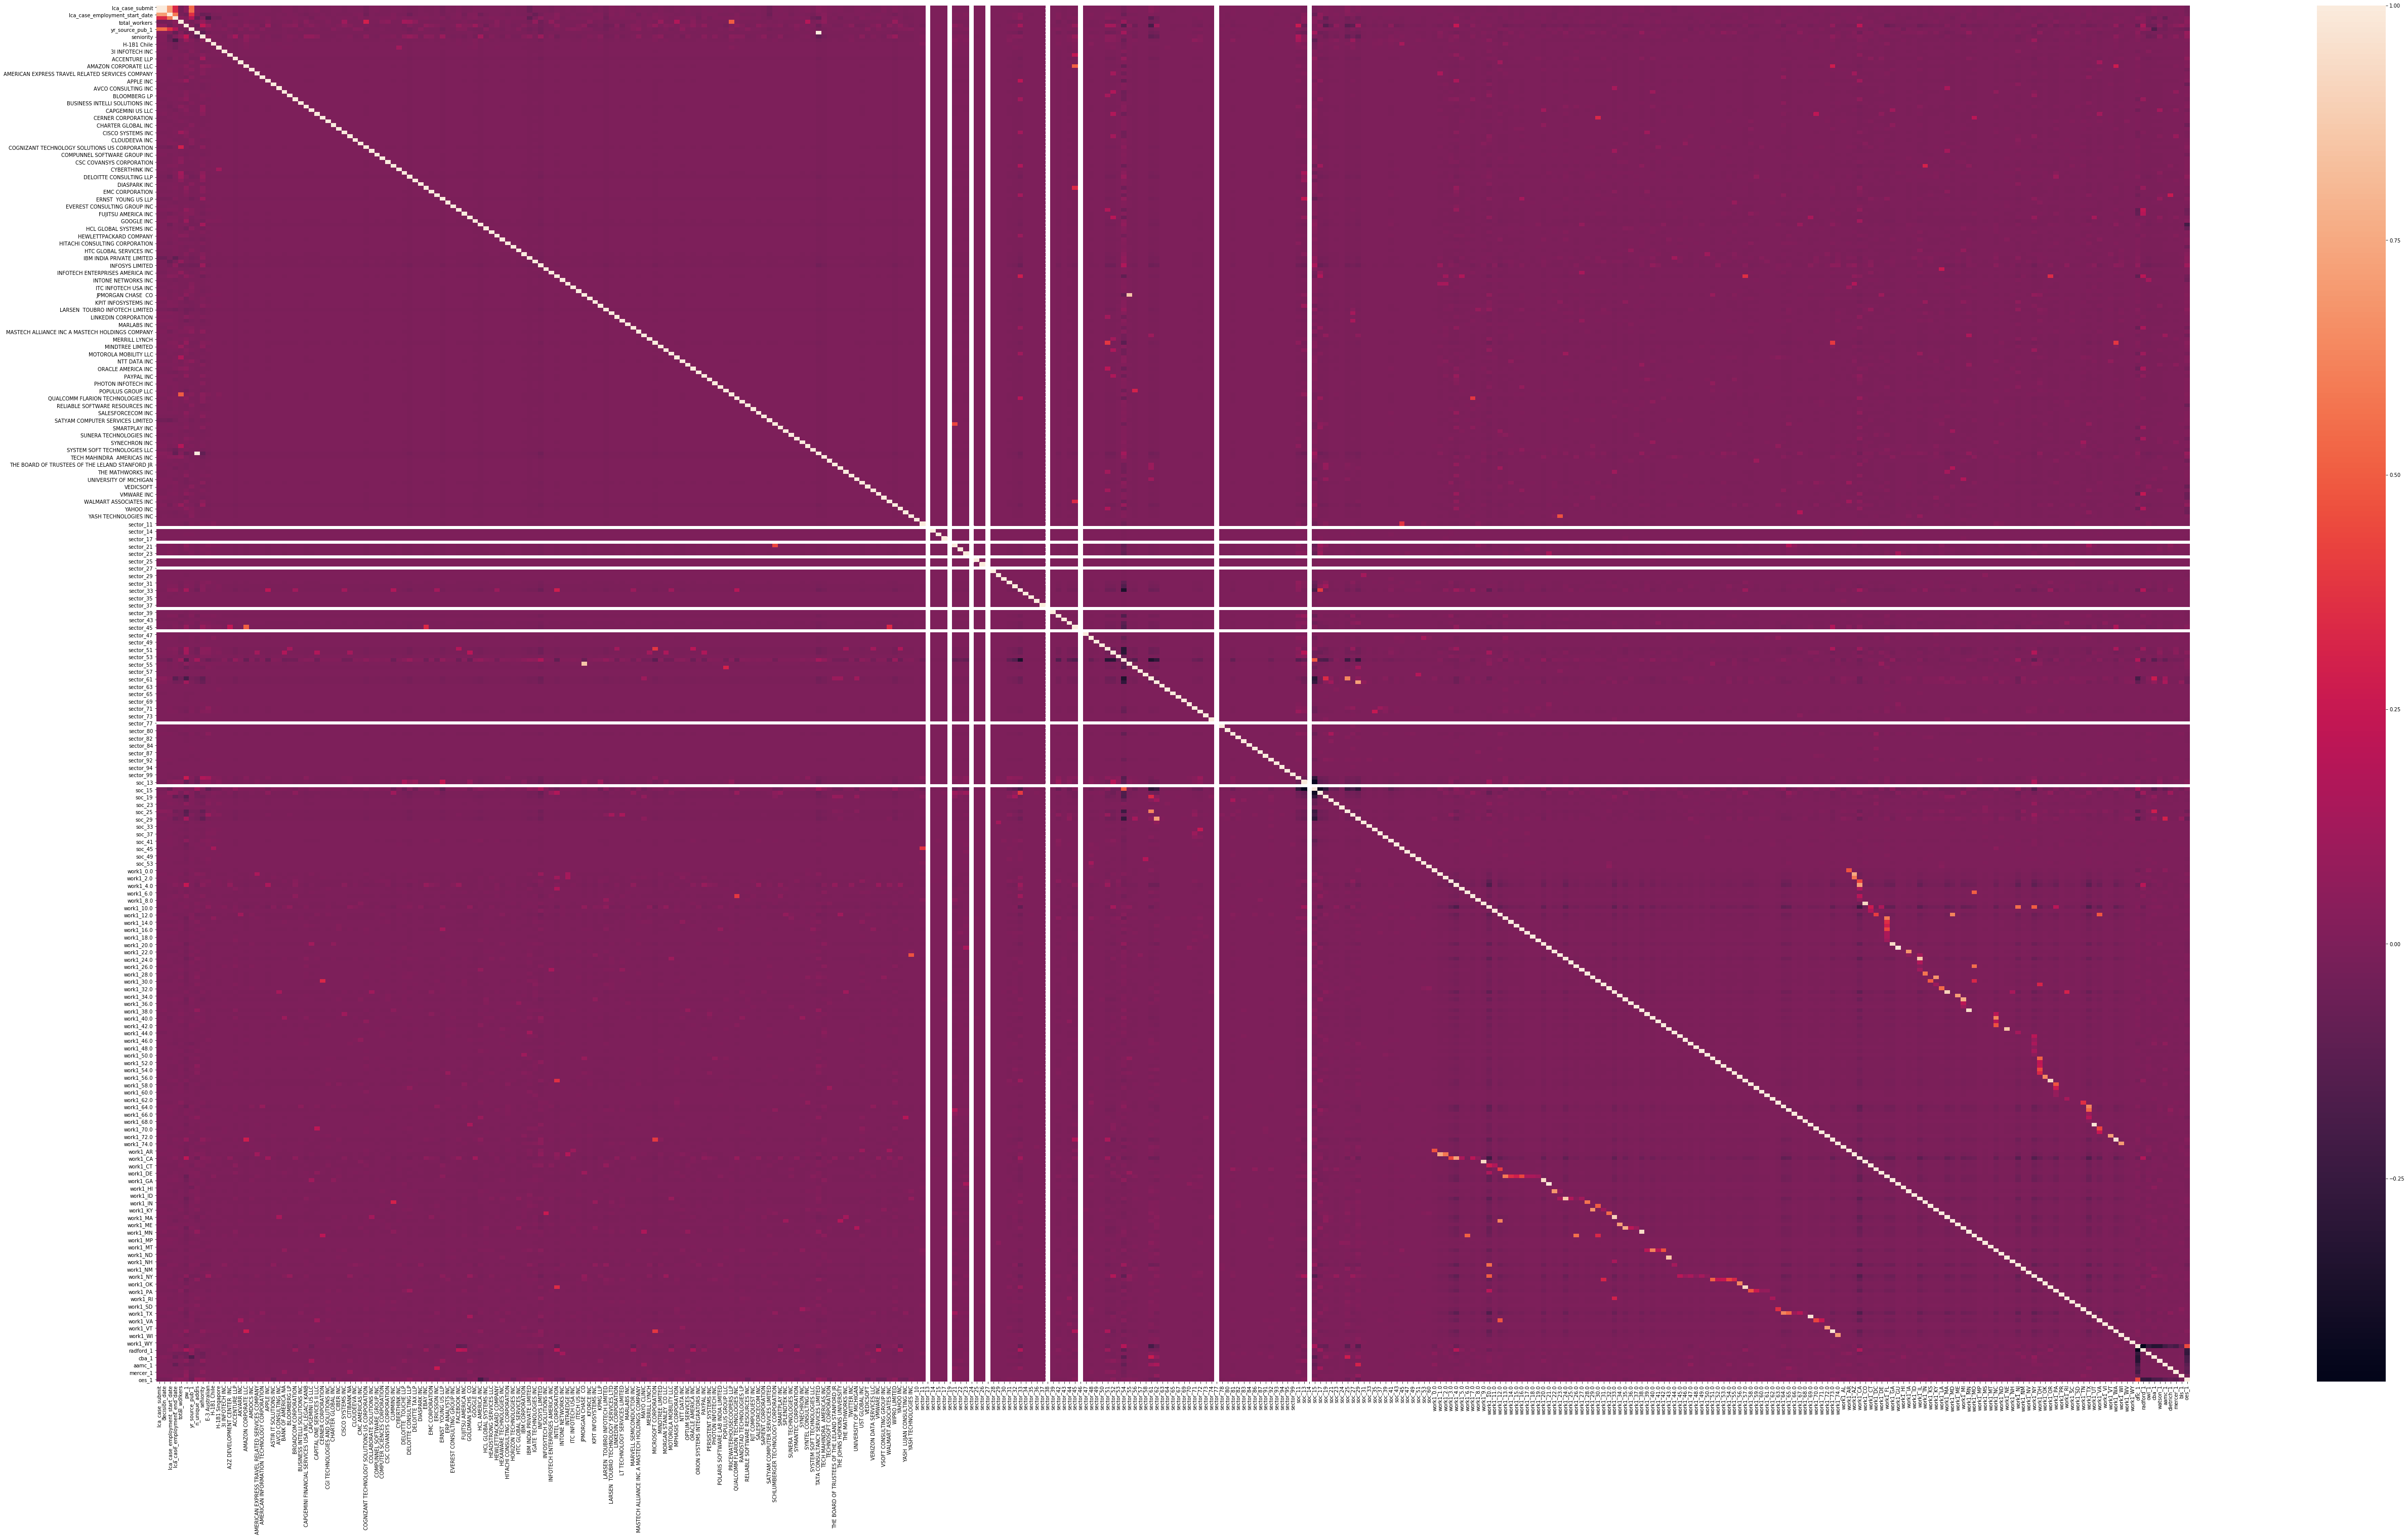

In [130]:
fig = plt.figure(figsize=(90, 50))
sns.heatmap(Xcorr)

In [144]:
# seems a couple of these columns need to go, perhaps they are only meaningful in the workloc2 data
Xcorr["YASH TECHNOLOGIES INC"]
Xcorr["sector_11"]
Xcorr["YAHOO INC"]
Xcorr["sector_21"]
np.corrcoef(dmat["sector_13"].values.flatten(), dmat.decision_date.values.flatten())
Xcorr.soc_14
np.corrcoef(dmat["soc_14"].values.flatten(), dmat.decision_date.values.flatten())
Xtrain.info()
np.corrcoef(dmat["sector_77"].values.flatten(), dmat.sector_13.values.flatten())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 332182 entries, 1500 to 151551
Columns: 373 entries, lca_case_submit to oes_1
dtypes: float64(7), int64(12), uint8(354)
memory usage: 162.8 MB


array([[  1.00000000e+00,  -2.25780014e-06],
       [ -2.25780014e-06,   1.00000000e+00]])

In [138]:
npXcorr = np.corrcoef(Xtrain.values.T)

/home/kilian/.envs/elucd/lib/python3.6/site-packages/numpy/lib/function_base.py:3167: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/kilian/.envs/elucd/lib/python3.6/site-packages/numpy/lib/function_base.py:3168: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


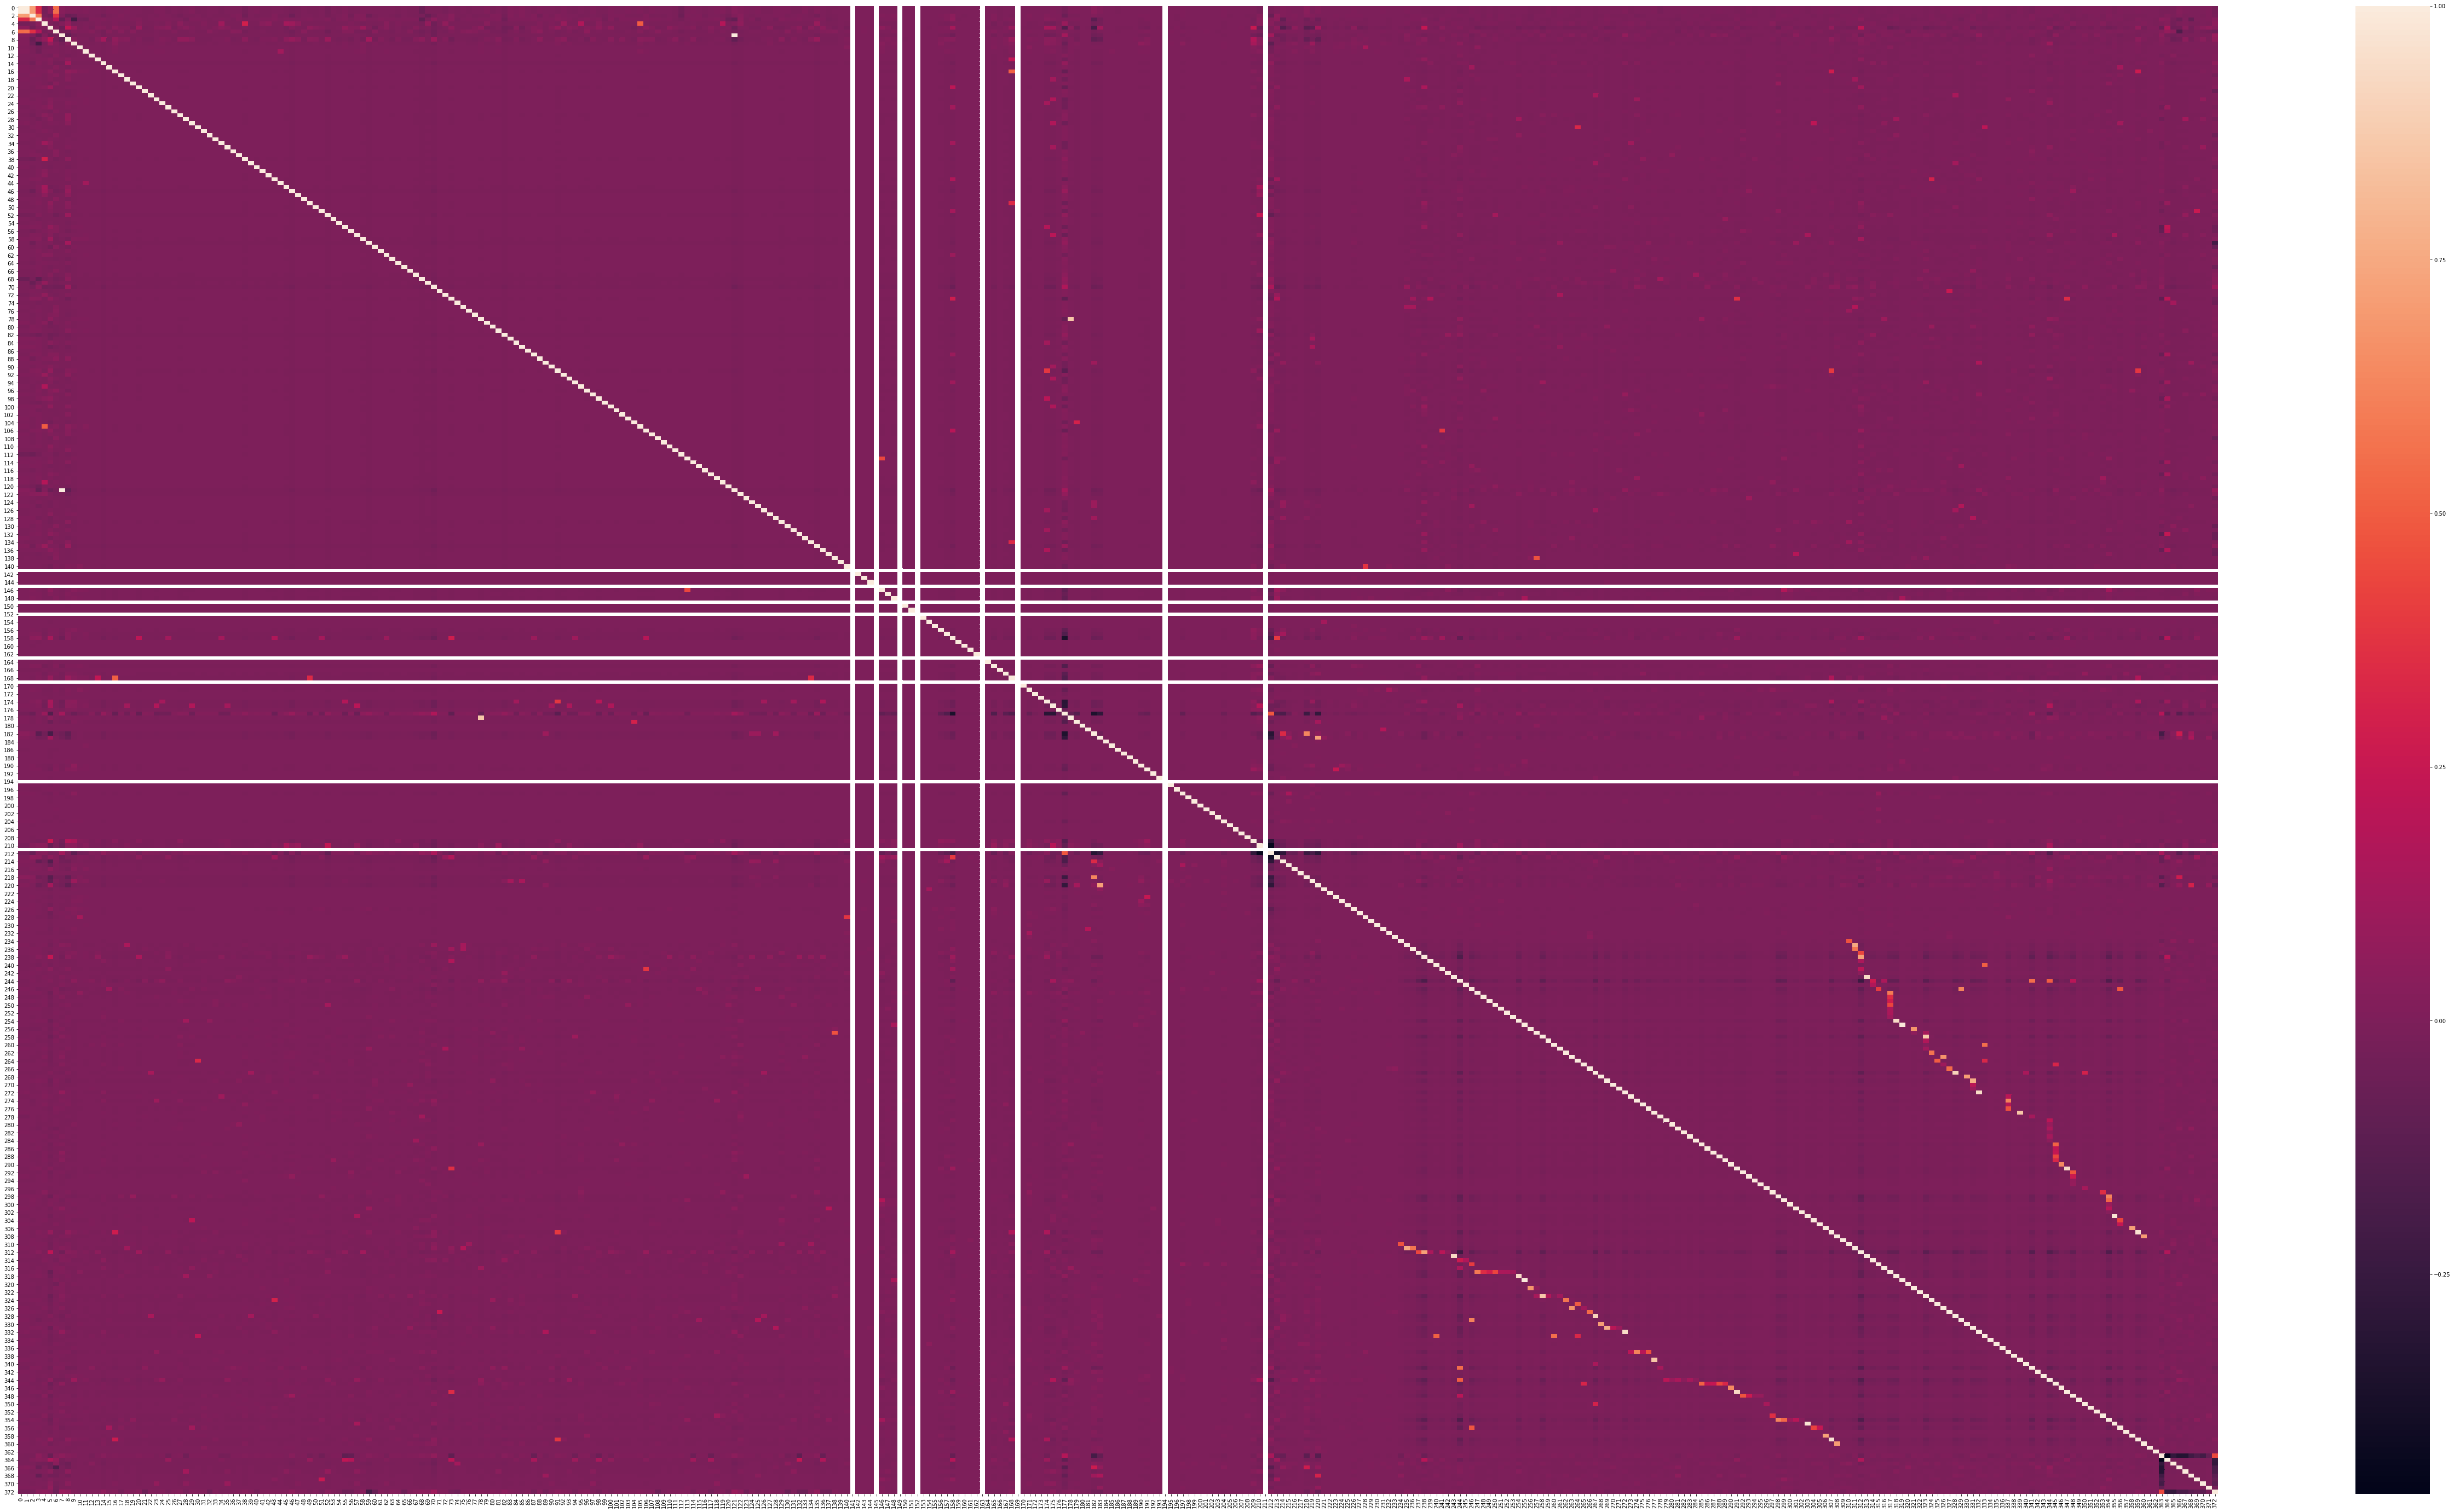

In [140]:
fig = plt.figure(figsize=(90, 50))
sns.heatmap(npXcorr)

In [147]:
subcorr = np.ma.corrcoef(Xtrain.values[:, 50:250].T)

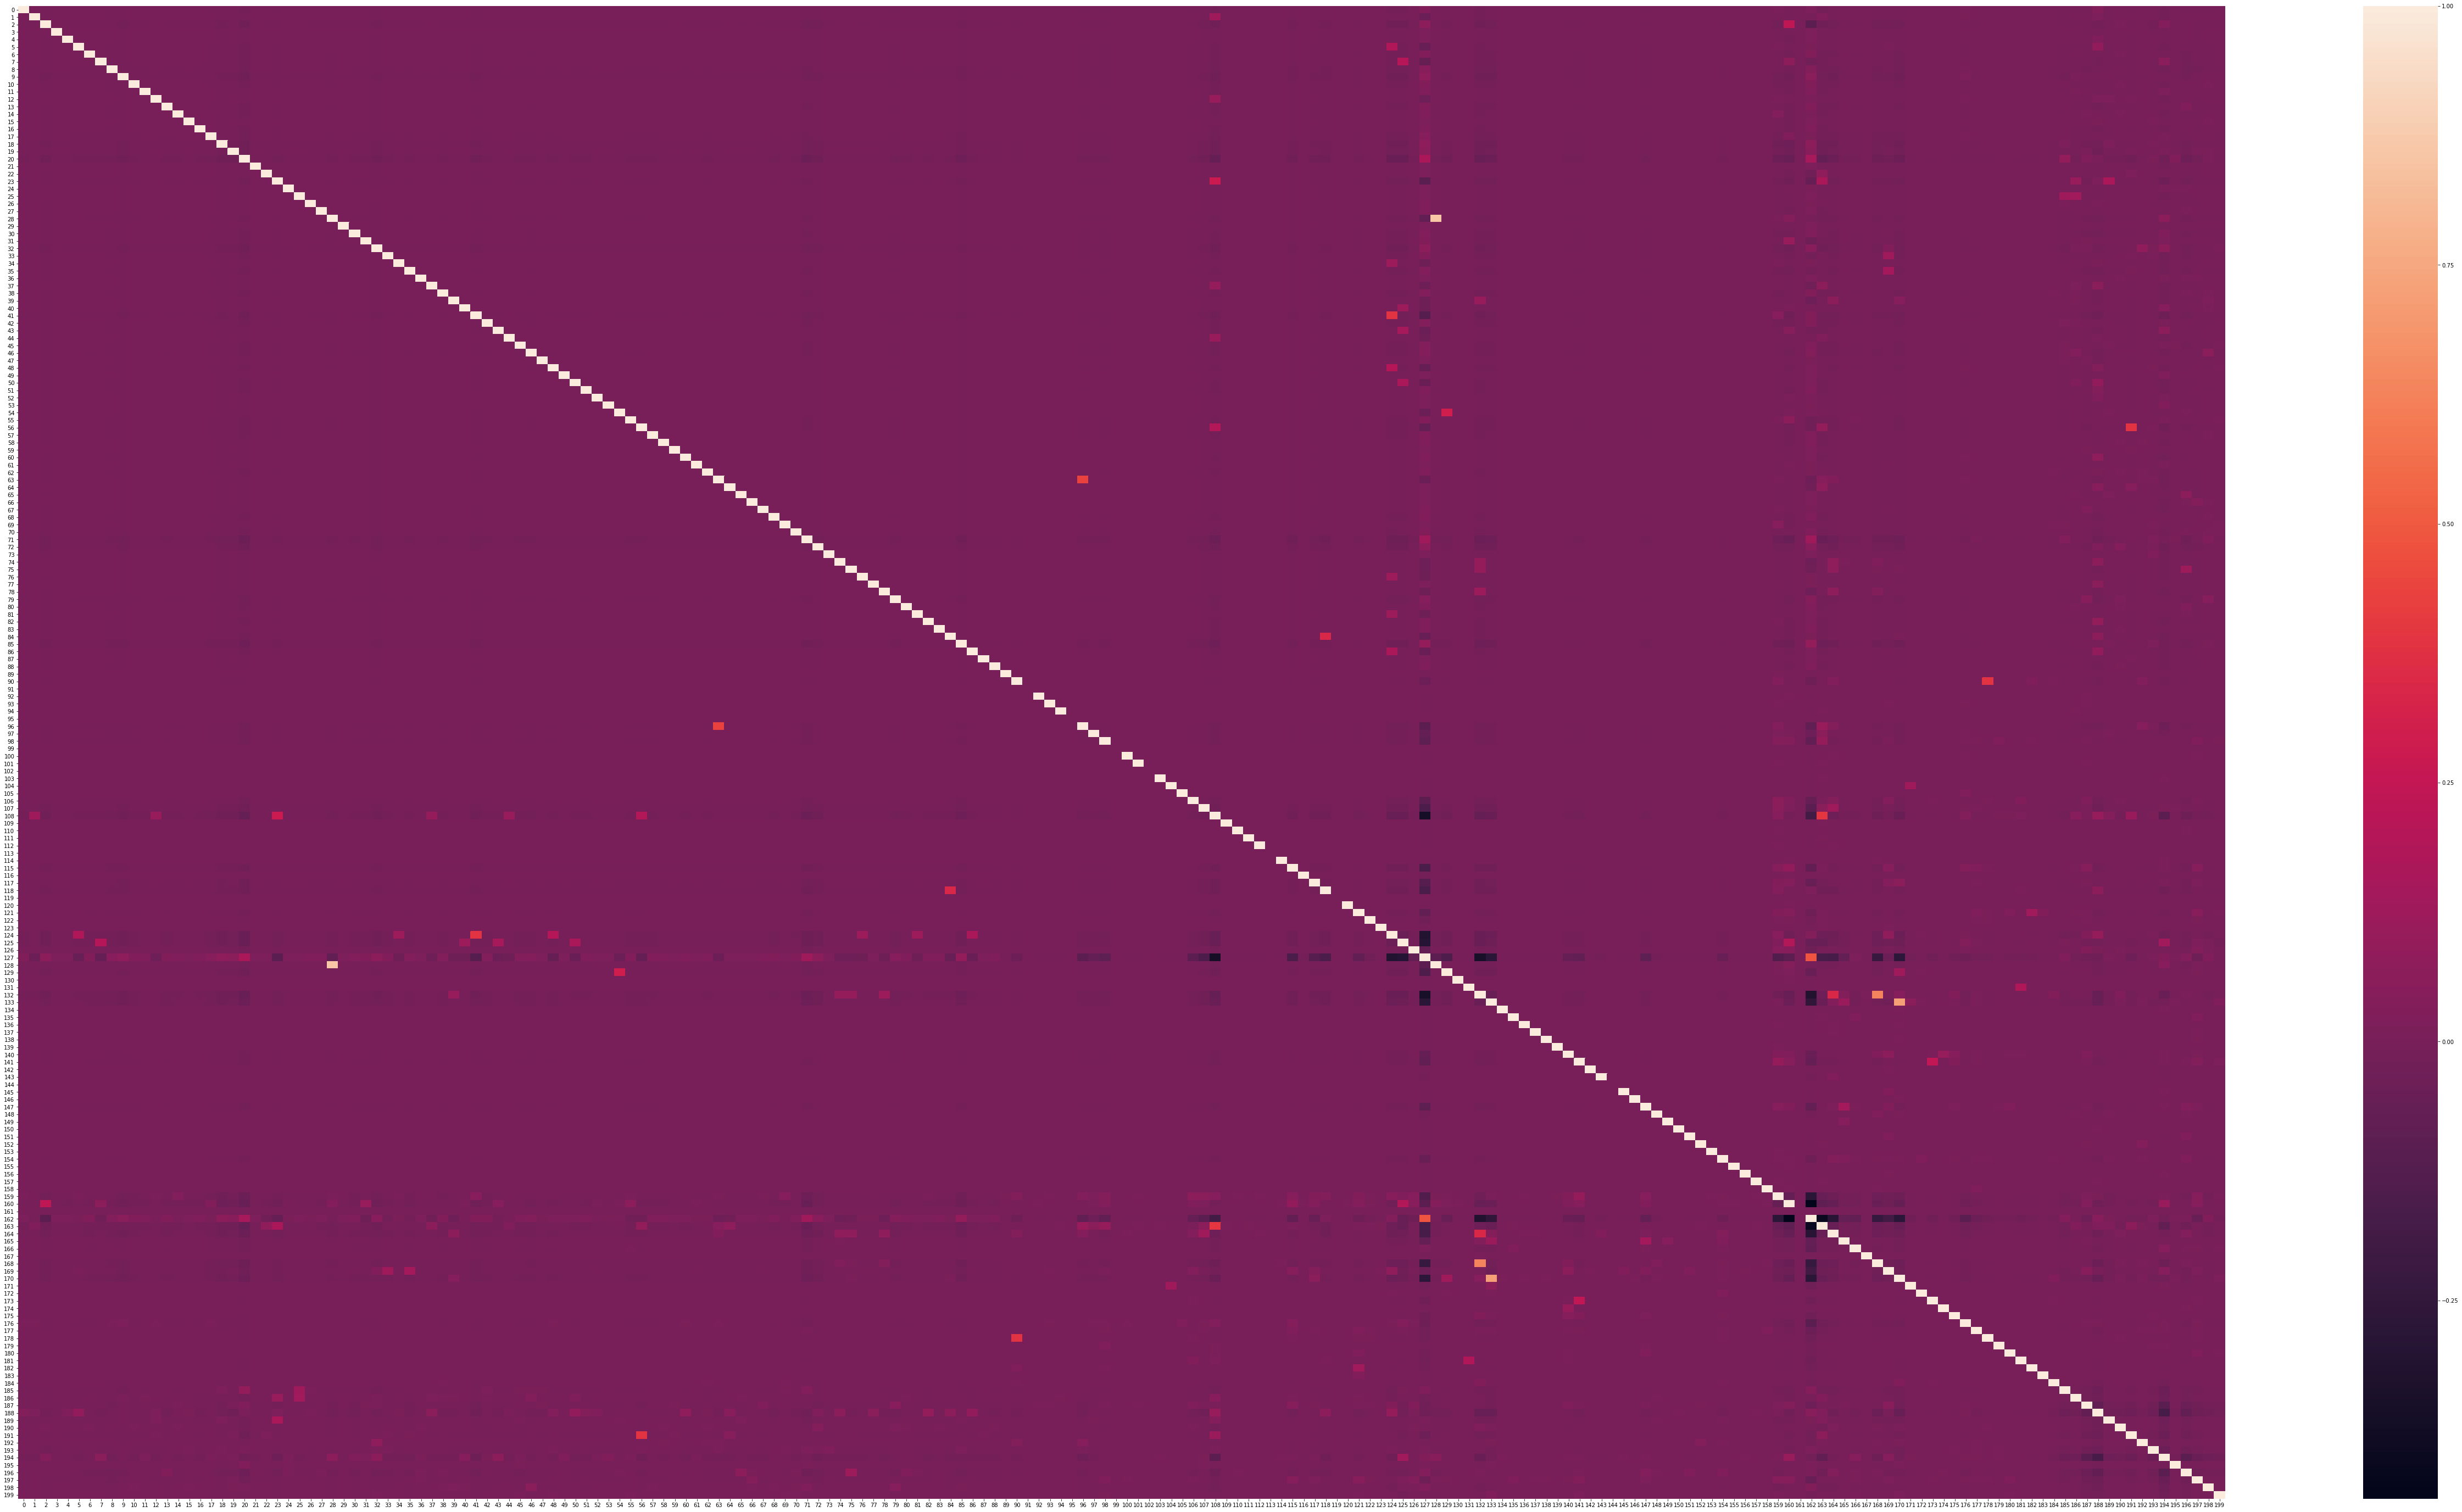

In [148]:
# I think they are actually just artifacts of computing corrcoef for such a large dataset
# the correlations seem fine with subsets of the columns, so I'm going to leave them
# it is a little worrisome though...
fig = plt.figure(figsize=(90, 50))
sns.heatmap(subcorr)

In [149]:
# let's try a quick random forest so
clf = RFC()
clf.fit(Xtrain, ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

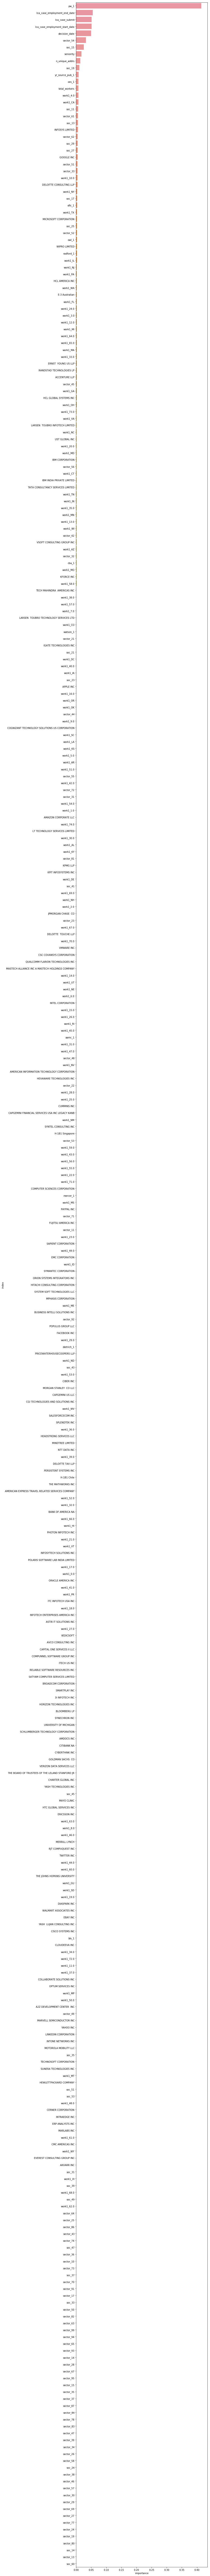

In [158]:
# let's have a look at what variables were most important
fig = plt.figure(figsize=(10, 200))
impdf = pd.DataFrame(clf.feature_importances_, index=Xtrain.columns, columns=["importance"])
impdf = impdf.sort_values("importance", ascending=False).reset_index()
sns.barplot(x="importance", y="index", data=impdf)

In [167]:
print(ytrain.shape)
print(Xtrain.shape)

(332182,)
(332182, 373)


/home/kilian/.envs/elucd/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/home/kilian/.envs/elucd/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  if __name__ == '__main__':
/home/kilian/.envs/elucd/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
htt

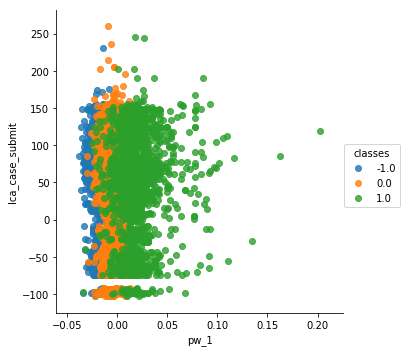

In [179]:
# take a look at some scatter plots with important features

# use a random subsample of 10k so that my computer doesn't fry
mask = np.random.choice(Xtrain.shape[0], size=10000)

# add y values to Xtrain just for plotting
Xtrain["classes"] = ytrain.values

sns.lmplot(x="pw_1", y="lca_case_submit", hue="classes", data=Xtrain.loc[mask, :], fit_reg=False)


/home/kilian/.envs/elucd/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
/home/kilian/.envs/elucd/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


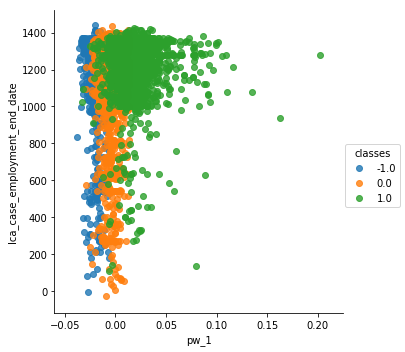

In [180]:
sns.lmplot(x="pw_1", y="lca_case_employment_end_date", hue="classes", data=Xtrain.loc[mask, :], fit_reg=False)

/home/kilian/.envs/elucd/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
/home/kilian/.envs/elucd/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


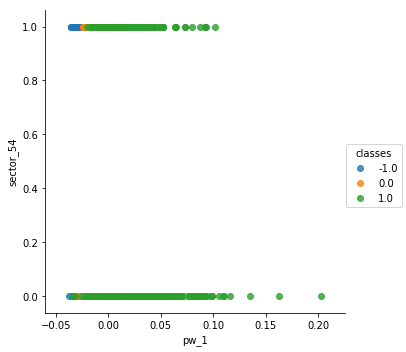

In [181]:
sns.lmplot(x="pw_1", y="sector_54", hue="classes", data=Xtrain.loc[mask, :], fit_reg=False)

/home/kilian/.envs/elucd/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
/home/kilian/.envs/elucd/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


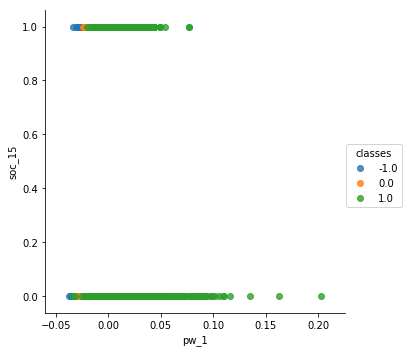

In [182]:
sns.lmplot(x="pw_1", y="soc_15", hue="classes", data=Xtrain.loc[mask, :], fit_reg=False)

/home/kilian/.envs/elucd/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
/home/kilian/.envs/elucd/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


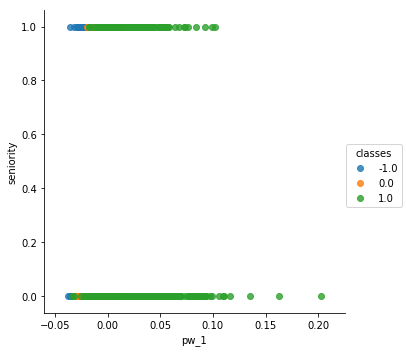

In [183]:
sns.lmplot(x="pw_1", y="seniority", hue="classes", data=Xtrain.loc[mask, :], fit_reg=False)

/home/kilian/.envs/elucd/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
/home/kilian/.envs/elucd/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


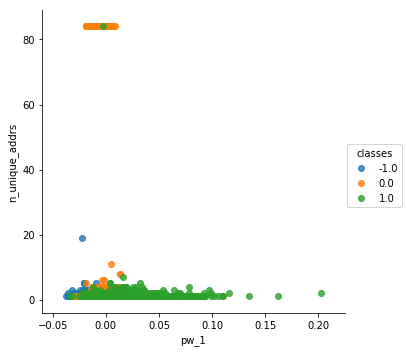

In [184]:
sns.lmplot(x="pw_1", y="n_unique_addrs", hue="classes", data=Xtrain.loc[mask, :], fit_reg=False)

/home/kilian/.envs/elucd/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
/home/kilian/.envs/elucd/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


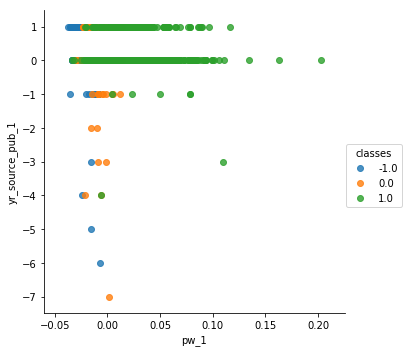

In [185]:
sns.lmplot(x="pw_1", y="yr_source_pub_1", hue="classes", data=Xtrain.loc[mask, :], fit_reg=False)

In [57]:
n_samples = 300


# generate spherical data centered on (20, 20)
shifted_gaussian = np.random.randn(n_samples, 2) + np.array([20, 20])

# generate zero centered stretched Gaussian data
C = np.array([[0., -0.7], [3.5, .7]])
stretched_gaussian = np.dot(np.random.randn(n_samples, 2), C)

# concatenate the two datasets into the final training set
X_train = np.vstack([shifted_gaussian, stretched_gaussian])

# fit a Gaussian Mixture Model with two components
clf = mixture.GaussianMixture(n_components=2, covariance_type='full')
clf.fit(X_train)

# display predicted scores by the model as a contour plot
x = np.linspace(-20., 30.)
y = np.linspace(-20., 40.)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -clf.score_samples(XX)
Z = Z.reshape(X.shape)

CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 10))
CB = plt.colorbar(CS, shrink=0.8, extend='both')
plt.scatter(X_train[:, 0], X_train[:, 1], .8)

TypeError: 'numpy.float64' object is not iterable